# Detector Training using TorchVision

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image
from pycocotools.coco import COCO

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import box_iou

### Dataloader

The purpose of a DataLoader in PyTorch is to efficiently load, batch, shuffle, and transform data in parallel during training or inference, ensuring smooth and optimized data handling.

Refer to the link below for TorchVision and Dataloader

- Documentation: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
- https://medium.com/jumio/object-detection-tutorial-with-torchvision-82b8f269f6ff
- https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
- https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5

**NOTE**

Including **Attribute** to the model

- I believe we can add **attribute** here in the dataloader to train/fine tune the model.

In [2]:
class BuildingCOCODataset(torch.utils.data.Dataset):
    
    # Initialize Function
    def __init__(self, root, ann_file, transforms=None):
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms


    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.imgs[img_id]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        # Load the image
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path)

        # Get Annotation
        boxes = []
        labels = []

        for annotation in annotations:
            x, y, w, h = annotation['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(annotation['category_id'])

            ## We can add 'Attributes here'


        # Convert to Tensor
        img = ToTensor()(img)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels} ## Include Attribute in 'target'

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

### Data

In [13]:
root = '../split'
ann_file = 'coco/instances_default_6_modified.json'

train_dataset = BuildingCOCODataset(root=root, ann_file=ann_file)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


val_dataset = BuildingCOCODataset(root="../split", ann_file="coco/instances_default_5_modified.json")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


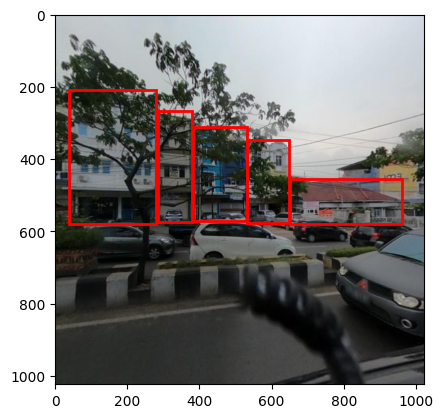

In [ ]:
# Sample Image from Dataset

img, target = train_dataset[1]
img = transforms.ToPILImage()(img)

fig, ax = plt.subplots(1)
ax.imshow(img)

for box in target['boxes']:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

### Model Training/Fine Tuning

Available Models/Backbones

https://pytorch.org/vision/main/models.html

Model Comparison

https://www.comet.com/anmorgan24/torchvision-object-detection/view/xhYVJ6hqqvNG537dFs9Q5Vxa0/panels



In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2 # Class: 2 (Building & Background)

model = fasterrcnn_resnet50_fpn(pretrained = True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
num_epoch = 10
losses = []

for epoch in range(num_epoch):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())
        epoch_loss += total_loss.item()

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
        
    lr_scheduler.step()
   
    print(f"Iteration: {epoch+1}, Loss: {total_loss.item()}")

Iteration: 1, Loss: 0.23294053971767426
Iteration: 2, Loss: 0.21091513335704803
Iteration: 3, Loss: 0.1632746160030365
Iteration: 4, Loss: 0.1304071992635727
Iteration: 5, Loss: 0.1211279034614563
Iteration: 6, Loss: 0.12423022091388702
Iteration: 7, Loss: 0.1090463176369667
Iteration: 8, Loss: 0.10938860476016998
Iteration: 9, Loss: 0.10959537327289581
Iteration: 10, Loss: 0.10526812076568604


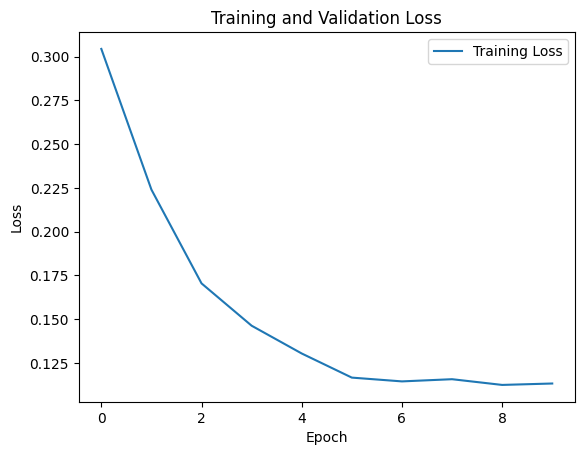

In [ ]:
plt.plot(losses, label='Training Loss')
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

**Mean Average Precision**

Refer to below link for mAP and IoU

- https://www.v7labs.com/blog/mean-average-precision


$$ \text{IoU} = \frac{\text{Intersection Area}}{\text{Union Area}} $$


In [ ]:
# Still working on Model Evaluation and Accuracy

mAP:  0.3628264790764791


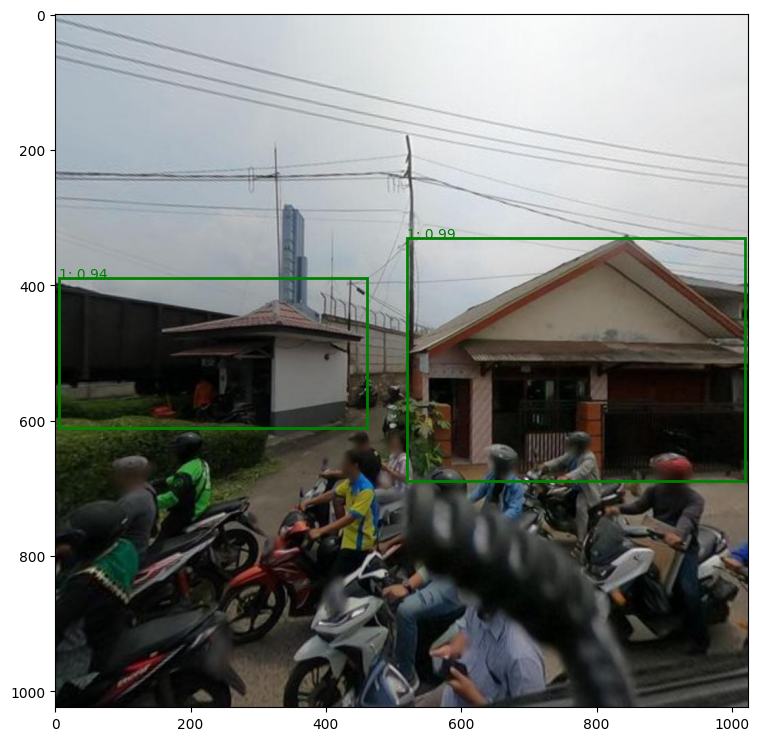

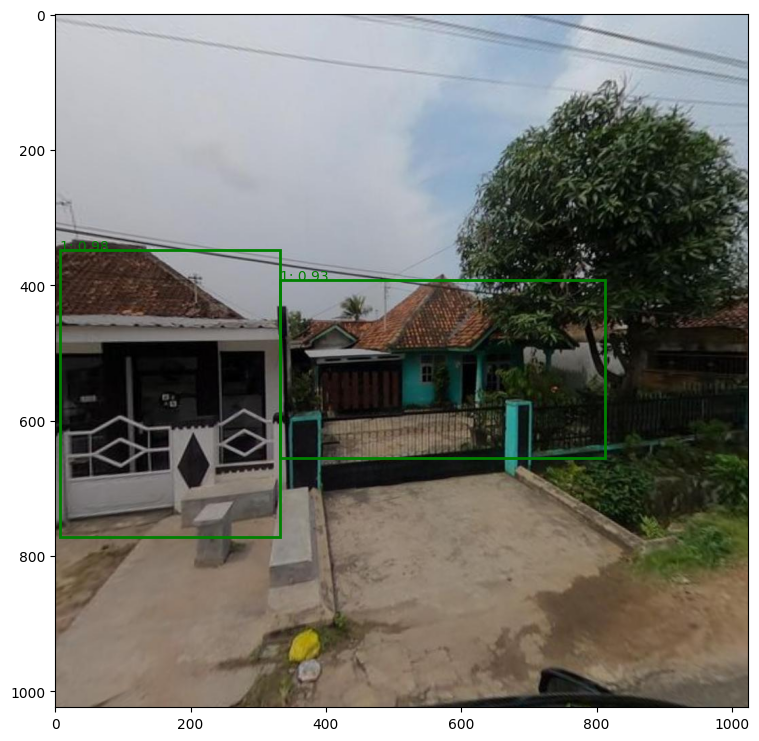

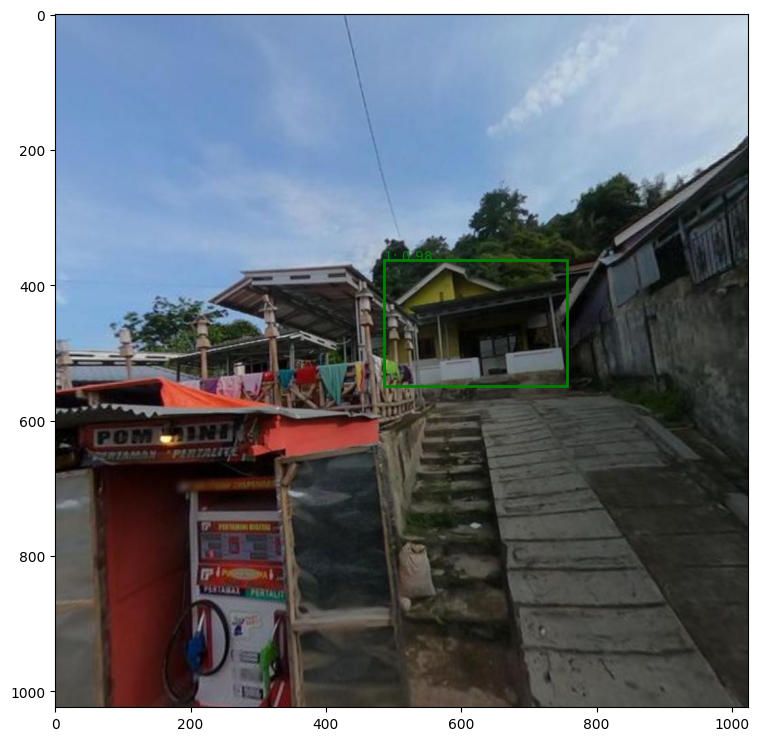

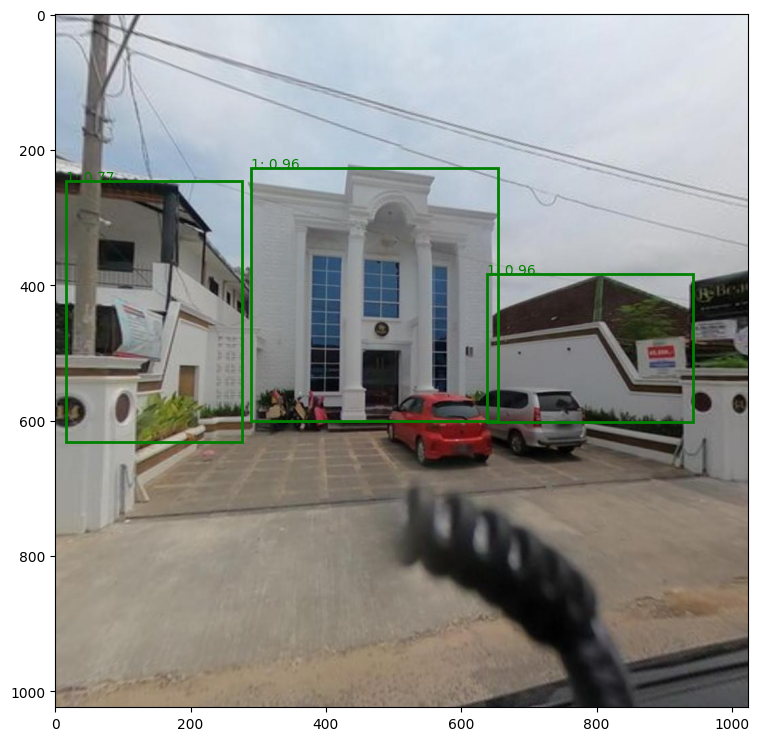

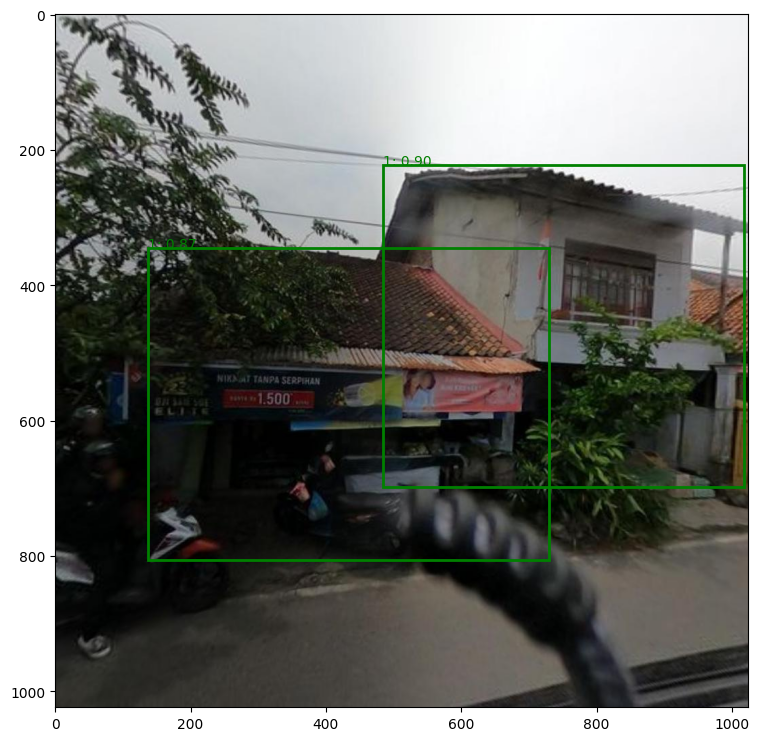

In [ ]:
def show_predictions(image, predictions, threshold=0.7):
    # Specify the 'threshold' if needed
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    
    boxes = predictions['boxes'].cpu()
    labels = predictions['labels'].cpu()
    scores = predictions['scores'].cpu()
    

    for i, box in enumerate(boxes):
        if scores[i] > threshold: 
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'{labels[i]}: {scores[i]:.2f}', color='g')
    
    plt.show()


model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = [image.to(device) for image in images]
        
        predictions = model(images)
        image = images[0].cpu().numpy().transpose(1, 2, 0)  
        
        # Visualize the predictions
        show_predictions(image, predictions[0])